### 对全部思路和解法进行重构
- 读取文件, 并将训练/测试集合并成一个大表来进行处理
- 数据清洗
    - 先针对离群点进行处理, 将离群点使用上下均值替换
    - 找到 0 值
- 然后做特征工程
    - 过去 10 个月的均值
    - 电阻
    - 二项式
- 使用 cv 划分训练测试集, 求取 cv=5 的平均 mse/score 值
- 使用 stacking 来构建模型

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 读取文件并连接

In [2]:
!ls ../../raw

clean_data.csv     public.test.csv    submit_example.csv train_data.csv
cleaned_data.csv   public.train.csv   test_data.csv


In [14]:
# 读取文件并合并
def concat_data(train_set, test_set):
    df_train = pd.read_csv(train_set)
    df_test = pd.read_csv(test_set)
    
    # 训练测试集合并成一个表进行处理
    df_all = pd.concat([df_train, df_test], sort=True).sort_values('ID').reset_index().drop('index', axis=1)
    
    return df_all

In [15]:
df_train = '../../raw/public.train.csv'
df_test = '../../raw/public.test.csv'

In [17]:
df_all = concat_data(df_train, df_test)

In [18]:
df_all.head()

,ID,光照强度,功率A,功率B,功率C,发电量,平均功率,板温,现场温度,电压A,...,电压C,电流A,电流B,电流C,转换效率,转换效率A,转换效率B,转换效率C,风向,风速
0,1,1,0.00,0.00,0.00,NaN,0.00,0.01,0.1,0,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.1
1,9,13,909.72,148.05,1031.03,NaN,696.27,-19.33,-17.5,722,...,721,1.26,0.21,1.43,198.32,259.11,42.17,293.66,273,0.3
2,10,34,976.86,155.98,1087.50,1.437752,740.11,-19.14,-17.4,729,...,725,1.34,0.22,1.50,80.55,106.32,16.98,118.36,272,0.6
3,11,30,1128.40,172.08,1132.56,1.692575,811.01,-18.73,-17.3,728,...,726,1.55,0.24,1.56,99.90,139.00,21.20,139.51,275,0.8
4,12,41,1279.25,166.06,1310.40,1.975787,918.57,-17.54,-17.0,731,...,720,1.75,0.23,1.82,82.48,114.86,14.91,117.66,283,1.1


## 清洗数据

In [60]:
# 用上下均值替换, 离群值
def clean_outlier(index, feautre):
    # 使用上下均值替代离群点
    values = []

    for idx in index:
        head = idx-1
        tail = idx+1

        while head in index:
            head -= 1

        while tail in index:
            tail += 1

        value = round((df_all.loc[head][feautre] + df_all.loc[tail][feautre])/2, 1)
        values.append(value)

    df_all.loc[index, feautre] = values

### 现场温度

In [20]:
tem_index = df_all[(df_all.现场温度 < -30) | (df_all.现场温度 > 50)][['现场温度']].index

In [22]:
clean_outlier(tem_index, '现场温度')

In [24]:
df_all.现场温度.describe()

count    17409.000000
mean         0.178385
std         10.124959
min        -21.500000
25%         -7.500000
50%         -2.400000
75%          8.300000
max         34.800000
Name: 现场温度, dtype: float64

### 功率A

In [25]:
df_all.功率A.describe()

count     17409.000000
mean       3008.554699
std       11618.226049
min           0.000000
25%        1189.000000
50%        2722.400000
75%        4253.850000
max      470096.580000
Name: 功率A, dtype: float64

In [33]:
def plot_points(feature):
    fig, ax = plt.subplots()
    ax.scatter(x = df_all[feature], y = df_all['发电量'])
    plt.ylabel('发电量', fontsize=13)
    plt.xlabel(feature, fontsize=13)
    plt.show()

In [41]:
powerA_index = df_all[df_all.功率A > 30000].index

In [42]:
clean_outlier(powerA_index, '功率A')

In [43]:
df_all.功率A.describe()

count    17409.000000
mean      2710.780487
std       1647.215206
min          0.000000
25%       1186.780000
50%       2718.980000
75%       4250.540000
max       7263.000000
Name: 功率A, dtype: float64

### 功率B

In [45]:
powerB_index = df_all[df_all.功率B > 30000].index

In [46]:
clean_outlier(powerB_index, '功率B')

In [47]:
df_all.功率B.describe()

count    17409.000000
mean      2720.930101
std       1677.077137
min          0.000000
25%       1163.360000
50%       2762.540000
75%       4257.440000
max      26802.110000
Name: 功率B, dtype: float64

### 功率C

In [48]:
powerC_index = df_all[df_all.功率C > 30000].index

In [49]:
powerC_index

Int64Index([127, 531, 673, 1178, 1520, 1561, 2214, 3108, 3136, 3253, 3254,
            3429, 6976],
           dtype='int64')

In [50]:
clean_outlier(powerC_index, '功率C')

In [51]:
df_all.功率C.describe()

count    17409.000000
mean      2764.108406
std       1680.279159
min          0.000000
25%       1226.420000
50%       2760.480000
75%       4323.880000
max      19561.200000
Name: 功率C, dtype: float64

### 平均功率

In [56]:
df_all.平均功率 = round((df_all.功率A + df_all.功率B + df_all.功率C)/3, 2)

In [57]:
df_all.平均功率.describe()

count    17409.000000
mean      2731.939684
std       1643.874101
min          0.000000
25%       1218.160000
50%       2739.330000
75%       4259.470000
max      10900.970000
Name: 平均功率, dtype: float64

### 电压A

In [62]:
df_all.电压A.describe()

count    17409.000000
mean       705.609570
std       1701.092389
min          0.000000
25%        641.000000
50%        669.000000
75%        689.000000
max      65515.000000
Name: 电压A, dtype: float64

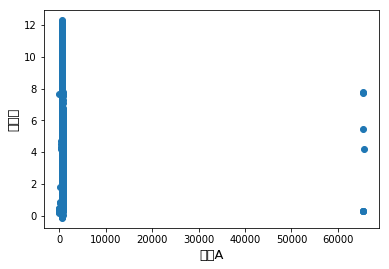

In [63]:
plot_points('电压A')

In [74]:
df_all[df_all.电压A > 2000][['ID','电压A']]

,ID,电压A
14,22,65382
859,948,65394
981,1070,65477
1065,1173,65408
1237,1362,65386
1419,1565,65420
2740,2986,65515
3303,3597,65419
3305,3599,65419
3309,3603,65420


In [75]:
voltageA_index = df_all[df_all.电压A > 2000].index

In [76]:
voltageA_index

Int64Index([14, 859, 981, 1065, 1237, 1419, 2740, 3303, 3305, 3309, 3311,
            3313],
           dtype='int64')

In [77]:
clean_outlier(voltageA_index, '电压A')

In [78]:
df_all.电压A.describe()

count    17409.000000
mean       660.995376
std         67.163162
min          0.000000
25%        641.000000
50%        669.000000
75%        689.000000
max        807.000000
Name: 电压A, dtype: float64

### 电压B

In [79]:
voltageB_index = df_all[df_all.电压B > 2000].index

In [80]:
clean_outlier(voltageB_index, '电压B')

In [81]:
df_all.电压B.describe()

count    17409.000000
mean       658.116520
std         68.108878
min          0.000000
25%        638.000000
50%        666.000000
75%        686.000000
max        831.000000
Name: 电压B, dtype: float64

### 电压C

In [82]:
voltageC_index = df_all[df_all.电压C > 2000].index

In [83]:
clean_outlier(voltageC_index, '电压C')

In [84]:
df_all.电压C.describe()

count    17409.000000
mean       657.582199
std         71.696055
min          0.000000
25%        638.000000
50%        666.000000
75%        686.000000
max        777.000000
Name: 电压C, dtype: float64

### 电流B

In [90]:
df_all.电流B.describe()

count    17409.000000
mean         4.555894
std         16.350305
min          0.000000
25%          1.730000
50%          4.120000
75%          6.530000
max        653.710000
Name: 电流B, dtype: float64

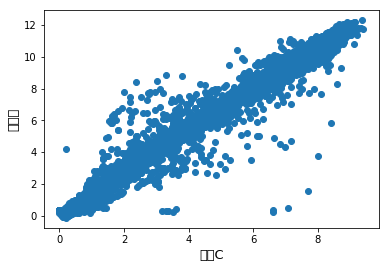

In [103]:
plot_points('电流C')

In [96]:
currentB_index = df_all[df_all.电流B > 100].index

In [97]:
clean_outlier(currentB_index, '电流B')

In [98]:
df_all.电流B.describe()

count    17409.000000
mean         4.148926
std          2.599035
min          0.000000
25%          1.730000
50%          4.120000
75%          6.520000
max         10.190000
Name: 电流B, dtype: float64

### 电流C

In [99]:
currentC_index = df_all[df_all.电流C > 100].index

In [100]:
clean_outlier(currentC_index, '电流C')

In [101]:
df_all.电流C.describe()

count    17409.000000
mean         4.211352
std          2.619048
min          0.000000
25%          1.800000
50%          4.100000
75%          6.600000
max         32.910000
Name: 电流C, dtype: float64

### 转换效率A

In [104]:
df_all.转换效率A.describe()

count     17409.000000
mean         57.102183
std        1471.721266
min           0.000000
25%          20.420000
50%          24.880000
75%          36.290000
max      183289.380000
Name: 转换效率A, dtype: float64

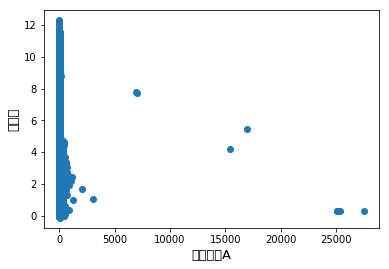

In [105]:
plot_points('转换效率A')

In [114]:
efficiencyA_index = df_all[df_all.转换效率A > 800].index

In [115]:
clean_outlier(efficiencyA_index, '转换效率A')

In [116]:
df_all.转换效率A.describe()

count    17409.000000
mean        35.145283
std         48.459740
min          0.000000
25%         20.420000
50%         24.870000
75%         36.270000
max        785.260000
Name: 转换效率A, dtype: float64

### 转换效率B

In [117]:
efficiencyB_index = df_all[df_all.转换效率B > 800].index

In [118]:
clean_outlier(efficiencyB_index, '转换效率B')

In [119]:
df_all.转换效率B.describe()

count    17409.000000
mean        35.077099
std         48.569005
min          0.000000
25%         20.250000
50%         24.880000
75%         36.700000
max        766.830000
Name: 转换效率B, dtype: float64

### 转换效率C

In [120]:
efficiencyC_index = df_all[df_all.转换效率C > 800].index

In [121]:
clean_outlier(efficiencyC_index, '转换效率C')

In [122]:
df_all.转换效率C.describe()

count    17409.000000
mean        36.150962
std         50.772028
min          0.000000
25%         20.560000
50%         25.380000
75%         36.870000
max        785.460000
Name: 转换效率C, dtype: float64

### 转换效率

In [123]:
df_all.转换效率 = round((df_all.转换效率A + df_all.转换效率B + df_all.转换效率C)/3, 2)

In [124]:
df_all.转换效率.describe()

count    17409.000000
mean        35.457769
std         48.035815
min          0.000000
25%         20.450000
50%         25.120000
75%         36.980000
max        763.590000
Name: 转换效率, dtype: float64

### 风速

In [125]:
df_all.风速.describe()

count    17409.000000
mean         2.373123
std          1.637846
min          0.000000
25%          1.200000
50%          2.200000
75%          3.300000
max         25.200000
Name: 风速, dtype: float64

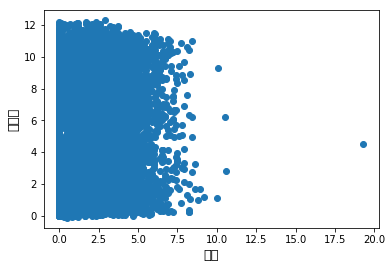

In [126]:
plot_points('风速')

In [130]:
speed_index = df_all[df_all.风速 > 20].index

In [131]:
clean_outlier(speed_index, '风速')

In [132]:
df_all.风速.describe()

count    17409.000000
mean         2.371831
std          1.628684
min          0.000000
25%          1.200000
50%          2.200000
75%          3.300000
max         19.300000
Name: 风速, dtype: float64

### 风向

In [133]:
direction_index = df_all[df_all.风向 > 360].index

In [134]:
clean_outlier(direction_index, '风向')

In [135]:
df_all.风向.describe()

count    17409.000000
mean       222.040295
std         96.967780
min          0.000000
25%        161.000000
50%        269.000000
75%        283.000000
max        359.000000
Name: 风向, dtype: float64

In [138]:
df_all.to_csv('../../raw/cleaned_data.csv')

## 特征工程

In [3]:
df_all = pd.read_csv('../../raw/cleaned_data.csv')

In [144]:
# # 求取电阻
# df_all['电阻A'] = df_all['电压A'] / (df_all['电流A'] + 0.0001)
# df_all['电阻B'] = df_all['电压B'] / (df_all['电流B'] + 0.0001)
# df_all['电阻C'] = df_all['电压C'] / (df_all['电流C'] + 0.0001)

In [7]:
df_all.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
# 切分数据集
df_train = df_all[df_all['发电量'] > -1]
df_test = df_all.drop(df_train.index, axis=0)

df_train.shape, df_test.shape

((9000, 21), (8409, 21))

In [9]:
# 去除重复值
df_train = df_train.drop_duplicates(df_train.columns.drop('ID'), keep='first')

In [10]:
y = df_train['发电量']
X = df_train.drop(['发电量','ID'], axis=1)

In [11]:
zero_id = df_test[df_test['平均功率'] == 0]['ID']

In [12]:
# 创建提交表格
df_sub = pd.DataFrame()

In [13]:
df_sub['ID'] = df_test['ID']

In [14]:
test_X = df_test.drop(['发电量', 'ID'], axis=1)

In [15]:
# 多项式特征
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)
X = poly.fit_transform(X)
test_X = poly.fit_transform(test_X)

In [16]:
X.shape, test_X.shape

((8918, 191), (8409, 191))

In [17]:
# 筛选特征
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor

sm = SelectFromModel(GradientBoostingRegressor(random_state=42))
train_X_sm = sm.fit_transform(X, y)
test_X_sm = sm.transform(test_X)

In [18]:
train_X_sm.shape, test_X_sm.shape

((8918, 52), (8409, 52))

## CV 模型训练

In [19]:
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import scipy as sp

In [20]:
folds = KFold(n_splits= 5, shuffle=True, random_state=42)

In [21]:
scores = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y.values)):
    train_x, train_y = X[train_idx], y.values[train_idx]
    valid_x, valid_y = X[valid_idx], y.values[valid_idx]
    
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_test = lgb.Dataset(valid_x, valid_y)

    params = {
    'learning_rate': 0.002,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.5,
    'num_leaves': 90,
    'min_data': 55,
    'min_hessian': 1,
    'verbose': -1,}

    gbm = lgb.train(params, lgb_train, 4000)
    pred = gbm.predict(valid_x)
    rmsetmp = sp.sqrt(sp.mean((valid_y - pred) ** 2))
    score = 1 / (1 + rmsetmp)

    print('This {} score is: '.format(n_fold+1) + str(score))
    scores.append(score)

This 1 score is: 0.8974336694116423
This 2 score is: 0.795797725021006
This 3 score is: 0.8901571642293844
This 4 score is: 0.8874038755919046
This 5 score is: 0.8376335130456765


- 电阻
```
This 0 score is: 0.8846821240584611
This 1 score is: 0.8894796734487159
This 2 score is: 0.8078416707467048
This 3 score is: 0.9026690288925423
This 4 score is: 0.8198826259908417
```

- 去掉电阻
```
This 1 score is: 0.8974336694116423
This 2 score is: 0.795797725021006
This 3 score is: 0.8901571642293844
This 4 score is: 0.8874038755919046
This 5 score is: 0.8376335130456765
```
The cv score is: 0.8617

In [22]:
# 计算平均数
def avg_score(num):
    nsum = 0
    for i in range(len(num)):
        nsum += num[i]
    return round(nsum / len(num), 4)

In [23]:
print('The cv score is: {}'.format(avg_score(scores)))

The cv score is: 0.8617


The cv score is: 0.8609

In [24]:
# 使用全部数据跑一遍 lightGBM

lgb_train = lgb.Dataset(X, y)
lgb_test = lgb.Dataset(test_X)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.5,
'num_leaves': 90,
'min_data': 55,
'min_hessian': 1,
'verbose': -1,}

gbm = lgb.train(params, lgb_train, 4000)
pred = gbm.predict(test_X)

In [25]:
df_sub['score'] = pred

In [26]:
index = df_sub[df_sub['ID'].isin(zero_id)].index
df_sub.loc[index, 'score'] = 0.379993053

In [27]:
df_sub.to_csv('./results/result_20180817b_lightgbm.csv', index=False, header=False)